In [45]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold

In [1]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

# low_glycemic_index

## Data Preprocessing

In [2]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'low_glycemic_index_1')

In [3]:
df['meal_ingredients'].isnull().sum()

0

In [4]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [5]:
df['meal_ingredients'].isnull().sum()

0

In [6]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '')
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)
    #processed_meal = " ".join(word for word in processed_meal.split() if word not in custom_stopwords)
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split())
    return(processed_meal)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [10]:
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 152
Total negative labels: 79
Total positive labels: 73


# TFIDF


## Meal Ingredients

In [11]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [12]:
df['meal_ingredients']

0                          Egg, turkey bacon, bread, tea
1                                     Raisin Bread 2 egg
2      Chicken enchilada, cheese, sour cream, rice, corn
3           Muffin bagel cream cheese jelly orange apple
4      Kraft deluxe Mac n cheese and. Mussels butter ...
                             ...                        
147    Lettuce, tomato, feta, rice/leaf thing, cucumb...
148                                    Soymilk, espresso
149    Spinach, kale, carrots, mushrooms, kidney bean...
150                                           Whole milk
151                           Frozen mango lil pineapple
Name: meal_ingredients, Length: 152, dtype: object

In [13]:
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [14]:
document

['Egg, turkey bacon, bread, tea',
 'Raisin Bread 2 egg',
 'Chicken enchilada, cheese, sour cream, rice, corn',
 'Muffin bagel cream cheese jelly orange apple',
 'Kraft deluxe Mac n cheese and. Mussels butter garlic sauce',
 'Mashed potatoes, curry chicken Irish potato, fried plantain, iced tea',
 'Cheeses noddle meat tomato sauce corn cob butter',
 'Bun cheese meat fry',
 'White rice; tofu; eggplant; string beans; carrot',
 'Chicken rice bean',
 'Oatmeal bread saltfish seasoning',
 '1 slice cheddar potato bread fair amount cream cheese',
 'Corn rice cheese',
 '99% fat free yogurt peach bottom',
 'Spaghetti meat sauce',
 'Corn',
 'Salt egg pepper waffle',
 '2 Hungry jack pancake 1 egg tea',
 'Strawberry, whole grain wheat, oats, barley, banana',
 'Chicken, bread',
 'Fried chicken thigh, wheat pasta macaroni cheese, mashed potato, biscuit, cob corn',
 'Chicken, bismati rice, lettuce, corn, olives, onions, chick pea',
 'Chicken, rice, chickpeas, broccoli, beets, pita hummus',
 'Skim milk,

In [15]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [17]:
print(X_train.shape, X_test.shape)

(121,) (31,)


In [23]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=40, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


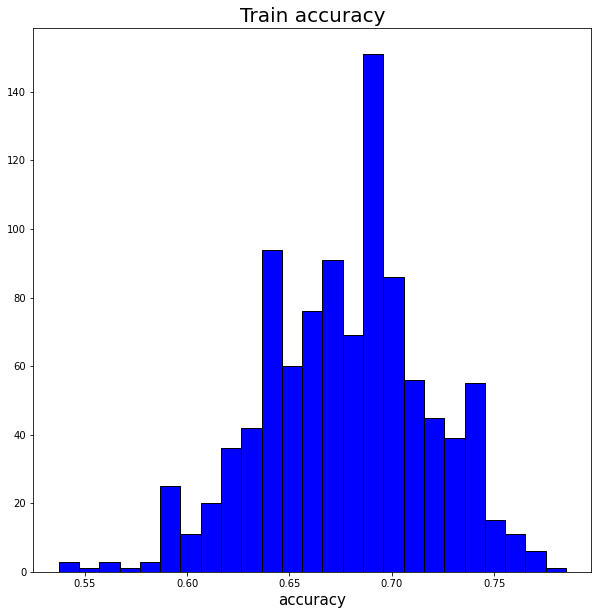

In [24]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [25]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6766776859504132
0.04038026677659665


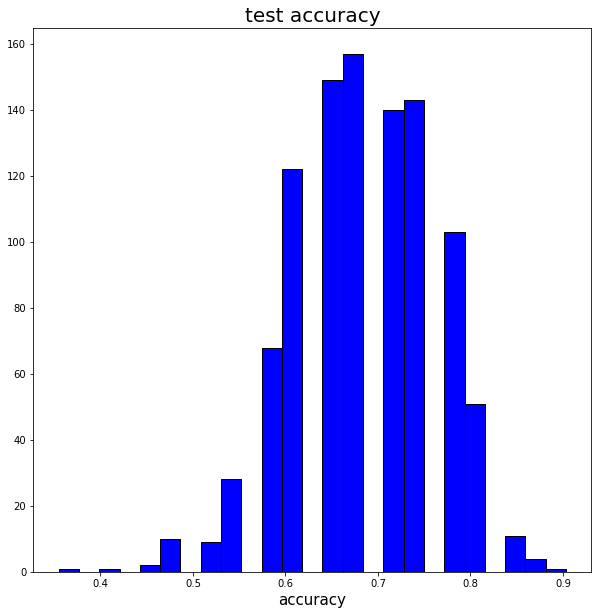

In [26]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [27]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6831935483870968
0.07520322103270623


# TFIDF Meal Title

In [28]:
df['meal_title'].isnull().sum()

0

In [29]:
df['meal_title'] = df['meal_title'].astype(str)

In [30]:
df = df.dropna(axis=0, subset=['meal_title'])

In [31]:
df['meal_title'].isnull().sum()

0

In [32]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [33]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [35]:
print(X_train.shape, X_test.shape)

(121,) (31,)


In [36]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

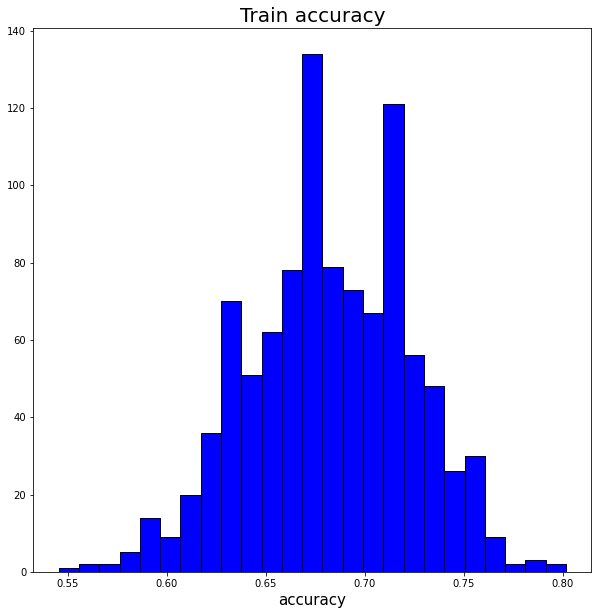

In [37]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [38]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6823884297520663
0.04116601763746233


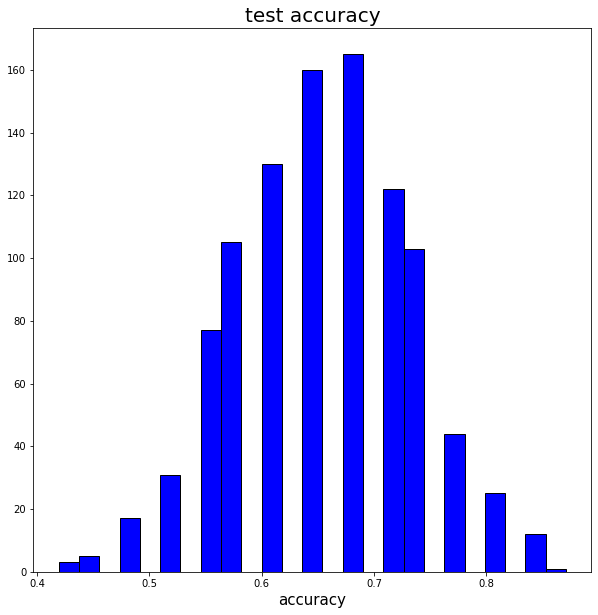

In [39]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [40]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6537741935483872
0.07775271642554019


# TFIDF Ingredients + Title

In [41]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [42]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [43]:
document

['Egg, turkey bacon, bread, tea American breakfast',
 'Raisin Bread 2 egg Bread and eggs',
 'Chicken enchilada, cheese, sour cream, rice, corn Lean cuisine',
 'Muffin bagel cream cheese jelly orange apple Morning snack',
 'Kraft deluxe Mac n cheese and. Mussels butter garlic sauce Mac n cheese and mussels',
 'Mashed potatoes, curry chicken Irish potato, fried plantain, iced tea Chicken and potatoes',
 'Cheeses noddle meat tomato sauce corn cob butter Ziti',
 'Bun cheese meat fry Cheeseburger cranberry juice fries',
 'White rice; tofu; eggplant; string beans; carrot Thai basil eggplant',
 'Chicken rice bean Spanish food',
 'Oatmeal bread saltfish seasoning Bread and Saltfish',
 '1 slice cheddar potato bread fair amount cream cheese Cream cheese on toast',
 'Corn rice cheese Pirates booty',
 '99% fat free yogurt peach bottom Yogurt',
 'Spaghetti meat sauce Spaghetti',
 'Corn Tortilla chips',
 'Salt egg pepper waffle Eggs and waffles',
 '2 Hungry jack pancake 1 egg tea Pancakes and eggs',

In [44]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [46]:
print(X_train.shape, X_test.shape)

(121,) (31,)


In [47]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


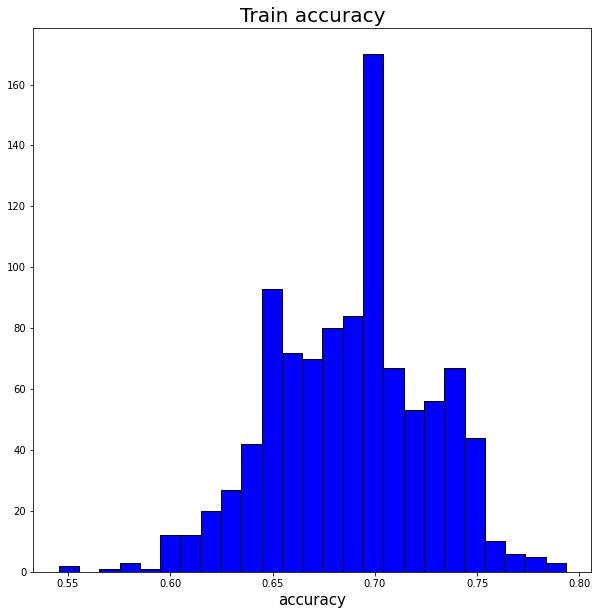

In [48]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [49]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.6871322314049587
0.03817837539485476


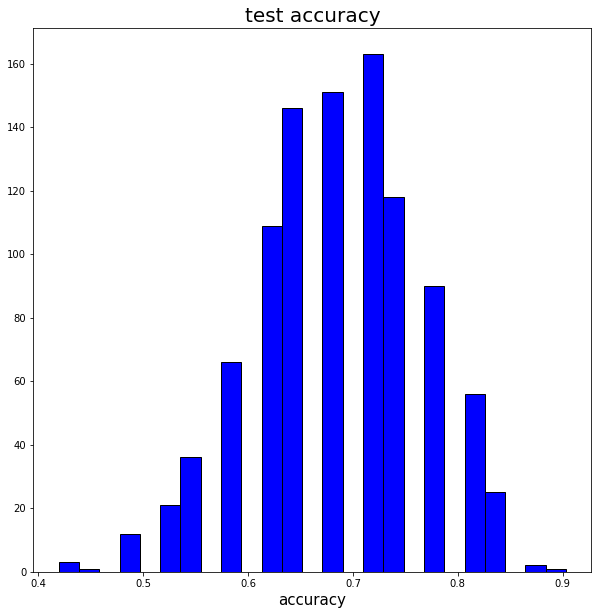

In [50]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [51]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.6813870967741936
0.07915968003199578


# Word2vec

## ingredients

In [52]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [53]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [54]:
meal_ingredients

0                       [egg, turkey, bacon, bread, tea]
1                                   [raisin, bread, egg]
2      [chicken, enchilada, cheese, sour, cream, rice...
3      [muffin, bagel, cream, cheese, jelly, orange, ...
4      [kraft, deluxe, mac, cheese, and, mussels, but...
                             ...                        
147    [lettuce, tomato, feta, rice, leaf, thing, cuc...
148                                  [soymilk, espresso]
149    [spinach, kale, carrots, mushrooms, kidney, be...
150                                        [whole, milk]
151                      [frozen, mango, lil, pineapple]
Name: meal_ingredients, Length: 152, dtype: object

In [55]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [56]:
learned_words_meal_ingredients

['chicken',
 'rice',
 'cheese',
 'bread',
 'egg',
 'corn',
 'sauce',
 'milk',
 'beans',
 'lettuce',
 'white',
 'spinach',
 'whole',
 'potato',
 'turkey',
 'tea',
 'tomato',
 'eggs',
 'broccoli',
 'brown',
 'fried',
 'orange',
 'wheat',
 'almonds',
 'pasta',
 'mushrooms',
 'green',
 'yogurt',
 'water',
 'carrots',
 'apple',
 'potatoes',
 'bacon',
 'beef',
 'carrot',
 'oatmeal',
 'peach',
 'pancake',
 'strawberry',
 'see',
 'meat',
 'sugar',
 'chocolate',
 'butter',
 'pineapple',
 'and',
 'oil',
 'kale',
 'codfish',
 'olive',
 'honey',
 'cheddar',
 'syrup',
 'fat',
 'grilled',
 'tortilla',
 'juice',
 'dressing',
 'pepper',
 'pumpkin',
 'sausage',
 'stew',
 'bagel',
 'salad',
 'cream',
 'raisin',
 'barley',
 'feta',
 'tahini',
 'avocado',
 'string',
 'blueberry',
 'alfredo',
 'beets',
 'bun',
 'grapes',
 'fry',
 'banana',
 'sweet',
 'bean',
 'pea',
 'chickpeas',
 'bbq',
 'smoothie',
 'handful',
 'macaroni',
 'skim',
 'grape',
 'onion',
 'pastry',
 'guava',
 'olives',
 'almond',
 'kidney',

In [57]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [58]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [59]:
data_y = np.squeeze(data_y)
data_y.shape

(152,)

In [60]:
data_X = pd.DataFrame(l)
data_X.shape

(152, 100)

In [61]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

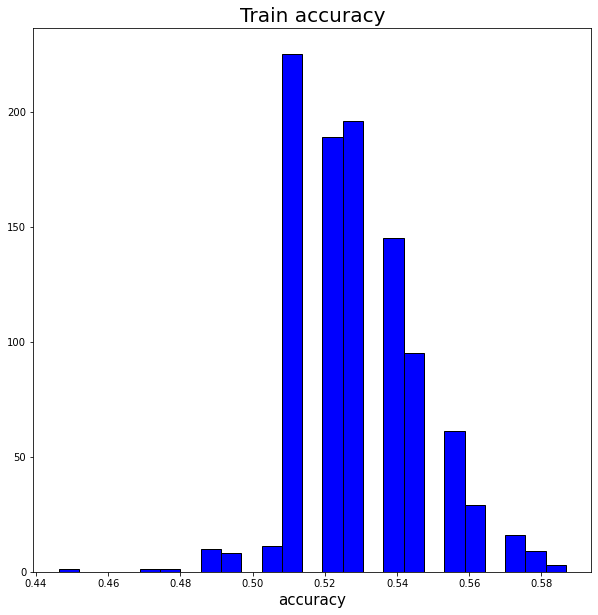

In [62]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [63]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5290247933884298
0.016855971109316494


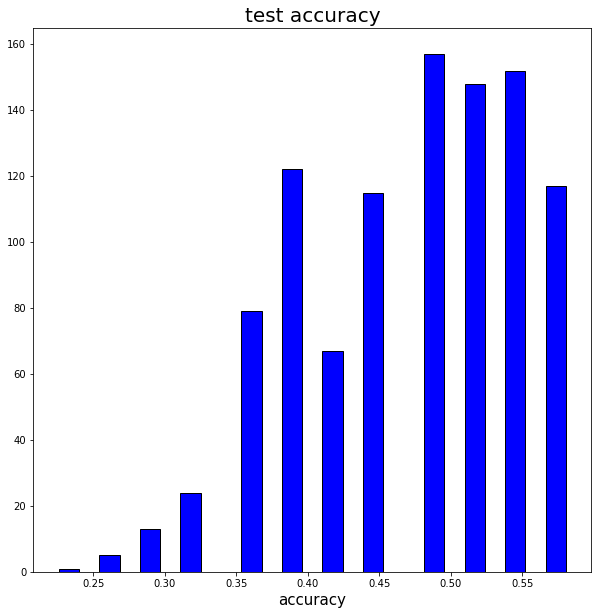

In [64]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [65]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.4719677419354838
0.07765313493507224


## title

In [66]:
df['meal_title'].isnull().sum()

0

In [67]:
df['meal_title'] = df['meal_title'].astype(str)

In [68]:
df = df.dropna(axis=0, subset=['meal_title'])

In [69]:
df['meal_title'].isnull().sum()

0

In [70]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [71]:
meal_title

0            [american, breakfast]
1               [bread, and, eggs]
2                  [lean, cuisine]
3                 [morning, snack]
4      [mac, cheese, and, mussels]
                  ...             
147                        [salad]
148            [small, soy, latte]
149                        [salad]
150                        [latte]
151              [mango, smoothie]
Name: meal_title, Length: 152, dtype: object

In [72]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [73]:
learned_words_meal_title

['and',
 'chicken',
 'eggs',
 'bread',
 'salad',
 'rice',
 'with',
 'fries',
 'cheese',
 'sandwich',
 'food',
 'whole',
 'grapes',
 'fish',
 'smoothie',
 'coffee',
 'turkey',
 'yogurt',
 'egg',
 'veggies',
 'water',
 'spaghetti',
 'soup',
 'beef',
 'oatmeal',
 'apple',
 'american',
 'blackberries',
 'saltfish',
 'bar',
 'meatballs',
 'bacon',
 'alfredo',
 'cheeseburger',
 'pancake',
 'orange',
 'breakfast',
 'cherries',
 'kind',
 'bbq',
 'bowl',
 'pizza',
 'boiled',
 'banana',
 'veggie',
 'latte',
 'sausage',
 'fried',
 'sweet',
 'pasta',
 'baked',
 'spinach',
 'grilled',
 'cake',
 'panera',
 'grain',
 'almonds',
 'chocolate',
 'dinner',
 'gf',
 'sauce',
 'french',
 'steak',
 'potatoes',
 'cereal',
 'chips',
 'eggplant',
 'fruit',
 'halal',
 'toast',
 'dried',
 'sesame',
 'snack',
 'lean',
 'cream',
 'same',
 'as',
 'tomato',
 'other',
 'plate',
 'spanish',
 'cornbread',
 'shoes',
 'jr',
 'mac',
 'basil',
 'thai',
 'juice',
 'on',
 'midnight',
 'cuisine',
 'cranberry',
 'morning',
 'zi

In [74]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [75]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [76]:
data_y = np.squeeze(data_y)
data_y.shape

(152,)

In [77]:
data_X = pd.DataFrame(l)
data_X.shape

(152, 100)

In [78]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

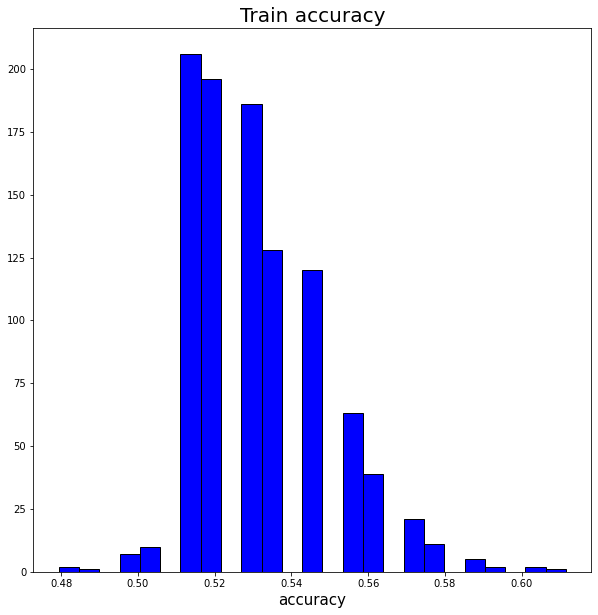

In [79]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [80]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5312396694214876
0.017716818663280717


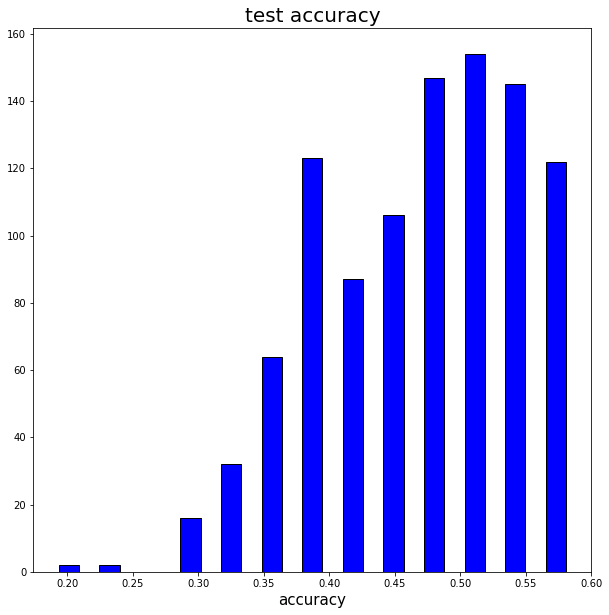

In [81]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [82]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.47145161290322574
0.07858514076869619


## ingredients_and_title

In [83]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [84]:
df['ingredients_and_title']

0       Egg, turkey bacon, bread, tea American breakfast
1                      Raisin Bread 2 egg Bread and eggs
2      Chicken enchilada, cheese, sour cream, rice, c...
3      Muffin bagel cream cheese jelly orange apple M...
4      Kraft deluxe Mac n cheese and. Mussels butter ...
                             ...                        
147    Lettuce, tomato, feta, rice/leaf thing, cucumb...
148                    Soymilk, espresso Small soy latte
149    Spinach, kale, carrots, mushrooms, kidney bean...
150                                     Whole milk Latte
151            Frozen mango lil pineapple Mango smoothie
Name: ingredients_and_title, Length: 152, dtype: object

In [85]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [86]:
meal_ingredients_title

0      [egg, turkey, bacon, bread, tea, american, bre...
1                 [raisin, bread, egg, bread, and, eggs]
2      [chicken, enchilada, cheese, sour, cream, rice...
3      [muffin, bagel, cream, cheese, jelly, orange, ...
4      [kraft, deluxe, mac, cheese, and, mussels, but...
                             ...                        
147    [lettuce, tomato, feta, rice, leaf, thing, cuc...
148               [soymilk, espresso, small, soy, latte]
149    [spinach, kale, carrots, mushrooms, kidney, be...
150                                 [whole, milk, latte]
151     [frozen, mango, lil, pineapple, mango, smoothie]
Name: ingredients_and_title, Length: 152, dtype: object

In [87]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [88]:
learned_words_meal_ingredients_title

['chicken',
 'and',
 'rice',
 'bread',
 'cheese',
 'egg',
 'eggs',
 'sauce',
 'whole',
 'turkey',
 'corn',
 'salad',
 'milk',
 'beans',
 'spinach',
 'potato',
 'lettuce',
 'yogurt',
 'tomato',
 'white',
 'orange',
 'water',
 'apple',
 'grapes',
 'fried',
 'tea',
 'bacon',
 'broccoli',
 'pasta',
 'fries',
 'wheat',
 'beef',
 'with',
 'oatmeal',
 'almonds',
 'pancake',
 'potatoes',
 'alfredo',
 'brown',
 'fish',
 'food',
 'chocolate',
 'sandwich',
 'smoothie',
 'carrots',
 'spaghetti',
 'mushrooms',
 'sweet',
 'banana',
 'green',
 'sausage',
 'blackberries',
 'coffee',
 'veggies',
 'grilled',
 'oil',
 'soup',
 'barley',
 'honey',
 'meatballs',
 'cream',
 'stew',
 'bbq',
 'kale',
 'syrup',
 'bagel',
 'pineapple',
 'sugar',
 'steak',
 'butter',
 'fry',
 'fruit',
 'cheddar',
 'juice',
 'pumpkin',
 'eggplant',
 'bun',
 'carrot',
 'bar',
 'saltfish',
 'strawberry',
 'codfish',
 'meat',
 'cereal',
 'peach',
 'tortilla',
 'pepper',
 'see',
 'dried',
 'ham',
 'french',
 'bowl',
 'american',
 'ra

In [89]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [90]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [91]:
data_y = np.squeeze(data_y)
data_y.shape

(152,)

In [92]:
data_X = pd.DataFrame(l)
data_X.shape

(152, 100)

In [93]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

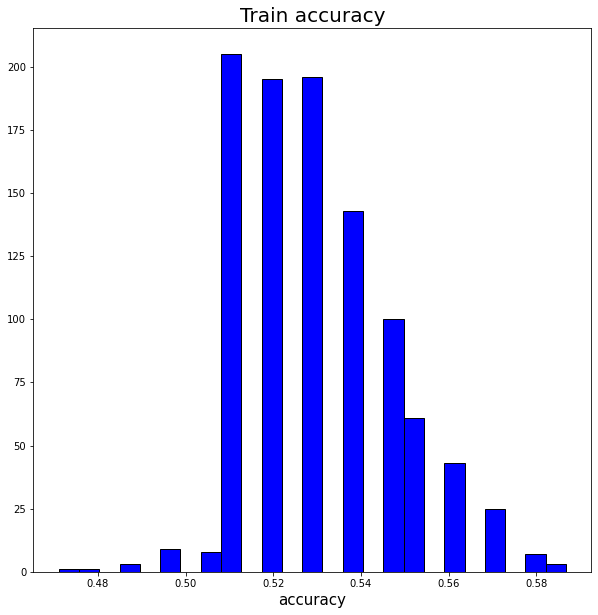

In [94]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [95]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.5305206611570248
0.01685170578029886


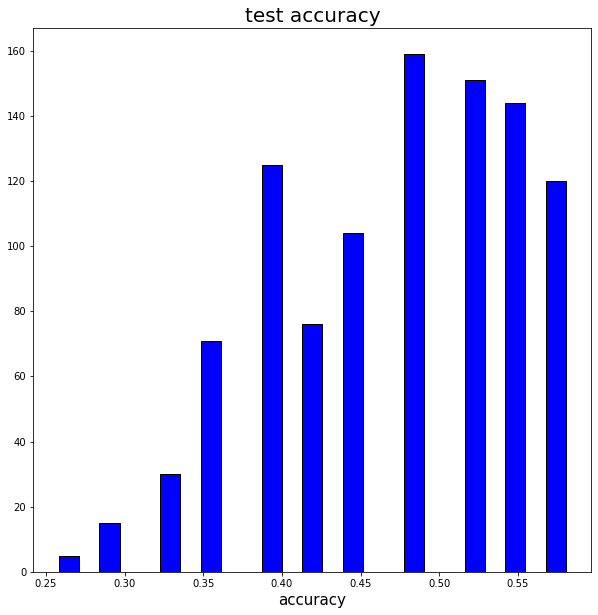

In [96]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [97]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.471258064516129
0.07807597223324532
